# Spektrální bisekce grafu

## Úvodní příklad

Uvažujeme řídkou matici o rozměrech $6 \times 6$ se symetrickou strukturou nenulových prvků, viz níže. Úkolem je rozdělit řádky (nebo sloupce) této matice tak, aby na každém z procesorů byl stejný počet řádků (*load balancing*) a při výpočtu součinu $y = Ax$ bylo provedeno co nejméně komunikací (*minimal cut*).

In [1]:
A = 2 * speye(6,6)

A[1, [2,3]] = [1,1]
A[2, [3,4]] = [1,1]
A[3, 6]     = 1
A[4, [5,6]] = [1,1]
A[5, 6]     = 1

A = A + transpose(A)
full(A)

6x6 Array{Float64,2}:
 4.0  1.0  1.0  0.0  0.0  0.0
 1.0  4.0  1.0  1.0  0.0  0.0
 1.0  1.0  4.0  0.0  0.0  1.0
 0.0  1.0  0.0  4.0  1.0  1.0
 0.0  0.0  0.0  1.0  4.0  1.0
 0.0  0.0  1.0  1.0  1.0  4.0

In [2]:
using PyPlot;

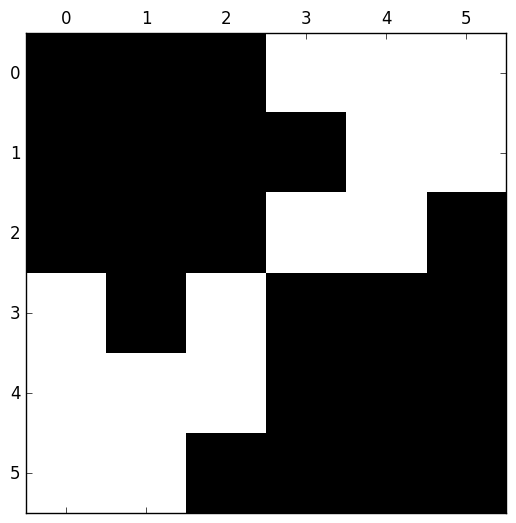

In [3]:
spy(full(A));

### Graf popisující strukturu matice

Strukturu nenulových prvků matice $A$ popíšeme pomocí grafu
$$
    \mathcal G = \{\mathcal V, \mathcal E\},
$$
kde 
 - $\mathcal V$ je množina vrcholů odpovídající řádkům matice, tj. $|\mathcal V|=n=6$ a 
 - $\mathcal E = \{ \{i,j\} : a_{ij} \ne 0 \land i\ne j \} $ je množina hran odpovídající nenulovým prvkům matice $A$.
 
Pozn. uvažujeme matice se symetrickou strukturou, tj. $\{i,j\} = \{j,i\}$.

V grafu zavedeme *libovolnou* orientaci (např. tak, že $i<j$). Pro tento **orientovaný** graf definujeme incidenční matici jako
$$
    E_{kj} = \left\{
    \begin{array}{ll}
        -1 & \mbox{pokud hrana $k$ vychází z vrcholu $i$,} \\
        1 & \mbox{pokud hrana $k$ vchází do vrcholu $i$,} \\
        0 & \mbox{jinak.} 
    \end{array}
    \right.
$$

In [4]:
function incidence_matrix(A)
    n = size(A,1)
    m = div((nnz(A) - n), 2)
    E = spzeros(m,n)
    rows = rowvals(A)
    k = 1
    for i = 1:n
        for  l in nzrange(A,i)
            j = rows[l]
            if i < j
                E[k,i] = -1.
                E[k,j] =  1.
                k+=1
            end
        end
    end
    return E
end

incidence_matrix (generic function with 1 method)

In [5]:
E = incidence_matrix(A)
full(E)

8x6 Array{Float64,2}:
 -1.0   1.0   0.0   0.0   0.0  0.0
 -1.0   0.0   1.0   0.0   0.0  0.0
  0.0  -1.0   1.0   0.0   0.0  0.0
  0.0  -1.0   0.0   1.0   0.0  0.0
  0.0   0.0  -1.0   0.0   0.0  1.0
  0.0   0.0   0.0  -1.0   1.0  0.0
  0.0   0.0   0.0  -1.0   0.0  1.0
  0.0   0.0   0.0   0.0  -1.0  1.0

Rozdělení vrcholů grafu na procesory $\mathcal V = \mathcal V_1 \cup \mathcal V_2$ ($\mathcal V_1 \cap \mathcal V_2 = \emptyset$) pak můžeme popsat pomocí vektoru $c \in \{-1,1\}^n$ takto:
$$
  c_i = \left\{
  \begin{array}{ll}
    -1 & \mbox{pokud } i \in \mathcal V_1, \\
    1 & \mbox{pokud } i \in \mathcal V_2.
  \end{array}
  \right.
$$

In [6]:
c = [1, -1, 1, -1, 1, -1]
c'

1x6 Array{Int64,2}:
 1  -1  1  -1  1  -1

Součin $E c$ pak je
$$
    (Ec)_k = \left\{
    \begin{array}{ll}
      0 & \mbox{pokud hrana $k$ začíná i končí ve stejné části grafu,} \\
      \pm 2 & \mbox{pokud hrana začíná ve $\mathcal V_1$ a končí $\mathcal V_2$ nebo naopak.} 
    \end{array}
    \right.
$$

In [7]:
(E*c)'

1x8 Array{Float64,2}:
 -2.0  0.0  2.0  0.0  -2.0  2.0  0.0  -2.0

Mohutnost řezu (počet hran spojující $\mathcal V_1$ s $\mathcal V_2$, tj. počet nutných komunikací při výpočtu součinu $y=Ax$) je potom $||Ec||^2/4$.

In [8]:
dot(E*c,E*c)/4

5.0

### Optimální řez grafu

Úlohu nalézt optimální řez grafu (se sudým počtem vrcholů) tedy můžeme formulovat takto: nalezněte vektor $c \in \{-1,1\}^n$ takový, že 
- $\sum_{i=1}^n c_i = (c, \vec{1}) = 0$ (load balancing)
- $c$ minimalizuje $||Ec||_2$
navíc z definice $c$ je vidět, že $||c||^2 = n$.

Tato úloha je však velmi obtížně řešitelná, proto přejdeme k přibližnému řešení v oboru reálných čísel.

## Spektrální bisekce grafu v oboru reálných čísel
Budeme uvažovat vektor $c \in \mathbb R^n$. Potom úlohu přeformulujeme takto: nalezněte reálný vektor $c\in \mathbb R^n$ takový, že
- $||c||=1$
- $(c,\vec{1}) = 0$
- $c$ minimalizuje $||Ec||^2 = (Ec,Ec)$.

Minimalizovaný výraz přepíšeme jako $||Ec||^2 = (Ec,Ec) = (E^TEc,c) = (Lc,c)$, kde $L=E^TE$

Matice $L$ se nazývá **Laplaceova matice** grafu a její prvky jsou
$$
    L_{ij} = \left\{
        \begin{array}{ll}
            |v_i| & \mbox{pro } i=j, \\
            -1 & \mbox{pro } a_{ij}\ne 0 \land i\ne j, \\
            0 & \mbox{jinak}
        \end{array}
    \right.
$$

In [9]:
L = transpose(E) * E
full(L)

6x6 Array{Float64,2}:
  2.0  -1.0  -1.0   0.0   0.0   0.0
 -1.0   3.0  -1.0  -1.0   0.0   0.0
 -1.0  -1.0   3.0   0.0   0.0  -1.0
  0.0  -1.0   0.0   3.0  -1.0  -1.0
  0.0   0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0  -1.0  -1.0  -1.0   3.0

Matice $L$ je symetrická pozitivně semidefinitní matice. Lze jí tedy diagonalizovat nad $\mathbb R$ a z jejích vlastních vektorů lze sestavit ortonormální bázi. Seřaďme vlastní čísla dle velikosti $0=\lambda_1 \le \lambda_2 \le ... \le \lambda_n$. Nechť $q_k$ je $k$-tý bázový vektor příslušející vlastnímu číslu $\lambda_k$ a $\gamma_k$ je $k$-tá souřadnice $c$ v této bázi (tj. $c=\sum \gamma_k q_k$), potom
$$
  1 = ||c||^2 = (c,c) = \sum_{k=1}^{n}{\gamma_k}^2,
$$
$$
    Lc = \sum \gamma_k L q_k = \sum \lambda_k \gamma_k q_k,
$$
a
$$
    (Lc,c) = \sum \lambda_k \gamma_k^2. 
$$

Dále platí $L \vec{1} = 0$ a tedy $\vec{1}$ je vlastní vektor odpovídající vlastnímu číslu $\lambda_1=0$. Minimalizaci $(Lc,c)$ tedy budeme provádět na ortogonálním doplňku $\vec{1}$, tj. na $span\{q_2,q_3,...,q_n\}$.

Je-li $\lambda_2$ jednonásobné, je $(Lc,c)$ řešením vektor $q_2$. 

In [10]:
sol=eig(full(L))
lambda = sol[1]'

1x6 Array{Float64,2}:
 4.44089e-15  1.0  3.0  3.0  4.0  5.0

In [11]:
q_2 = sol[2][:,2]'

1x6 Array{Float64,2}:
 -0.57735  -0.288675  -0.288675  0.288675  0.57735  0.288675

Vrcholy rozdělíme podle znamének prvků $q_2$

In [12]:
c=[-1,-1,-1,1,1,1]
dot(E*c,E*c)/4

2.0

## Příklad 2 - matice s lichým počtem řádků 

In [13]:
B = 2 * speye(7,7)

B[1, [2,3]] = [1,1]
B[2, [3,4]] = [1,1]
B[3, 6]     = 1
B[4, [5,6]] = [1,1]
B[5, [6,7]]     = 1
B[6,7] = 1
B = B + transpose(B)
full(B)

7x7 Array{Float64,2}:
 4.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  4.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  4.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  4.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  4.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  4.0  1.0
 0.0  0.0  0.0  0.0  1.0  1.0  4.0

In [14]:
EB = incidence_matrix(B);
LB = transpose(EB)*EB
solb = eig(full(LB))
solb[1]'

1x7 Array{Float64,2}:
 6.21725e-15  0.814349  2.32801  3.31391  3.59809  4.45753  5.48812

In [15]:
solb[2][:,2]

7-element Array{Float64,1}:
 -0.560099
 -0.347898
 -0.316183
  0.115898
  0.38428 
  0.216931
  0.507072

## Příklad 3 - dělení na 3 procesory

Matici $A$ ($n=6$) nejprve rozdělíme v poměru 1:2 na dva procesory, pak vetší díl rozdělíme opět na 2 procesory.

Původní matici modifikujeme tak, že přidáme řádky a nenulové prvky tak, aby nově přidané řádky tvořily s posledním vrcholem původního grafu kliku.

In [16]:
A1 = speye(8,8)
A = 2 * speye(6,6)

A1[1, [2,3]] = [1,1]
A1[2, [3,4]] = [1,1]
A1[3, 6]     = 1
A1[4, [5,6]] = [1,1]
A1[5, 6]     = 1

# Dodatečné prvky
A1[7,8] = 1

# Napojení na zbytek matice
A1[6,[7,8]] = 1

A1 = A1 + transpose(A1)
full(A1)

8x8 Array{Float64,2}:
 2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  2.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  2.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  2.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  2.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  2.0

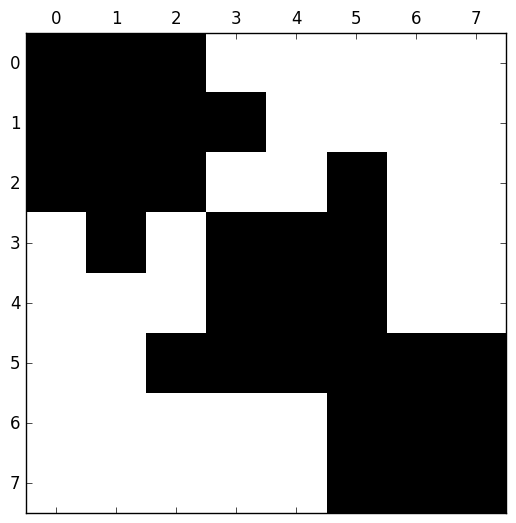

PyObject <matplotlib.image.AxesImage object at 0x7fd2d3345a90>

In [17]:
spy(full(A1))

In [18]:
E1 = incidence_matrix(A1);
L1 = transpose(E1)*E1
sol1 = eig(full(L1))
sol1[1]'

1x8 Array{Float64,2}:
 -3.60822e-16  0.666432  1.27766  3.0  3.0  3.45155  4.35771  6.24665

In [19]:
sol1[2][:,2]

8-element Array{Float64,1}:
 -0.504175 
 -0.368501 
 -0.303851 
 -0.0518964
  0.0837776
  0.16362  
  0.490513 
  0.490513 

## Nalezení vlastního vektoru $v_2$

Pro matici $L$ platí $\rho_L \le 2 \max_i L_{ii}$ (viz Geršgorinovo lemma)

In [20]:
maximum(eig(full(L1))[1])

6.24664560291511

In [21]:
ρ =  2*maximum(diag(L1))

10.0

In [22]:
n = size(L1)[1]
B = ρ*speye(n) - L1
eig(full(B))[1]'

1x8 Array{Float64,2}:
 3.75335  5.64229  6.54845  7.0  7.0  8.72234  9.33357  10.0

In [23]:
eig( B - ones(n,n)/n*ρ)[1]

8-element Array{Float64,1}:
 1.42109e-14
 3.75335    
 5.64229    
 6.54845    
 7.0        
 7.0        
 8.72234    
 9.33357    

In [24]:
v2 = rand(n)

8-element Array{Float64,1}:
 0.371421 
 0.952537 
 0.0954688
 0.614523 
 0.729738 
 0.852831 
 0.713263 
 0.326095 

In [25]:
for iter = 1:100
    v2 = B * v2 - ρ * ones(n,1)/n * sum(v2)
    v2 /= norm(v2)
end
v2

8x1 Array{Float64,2}:
 -0.505269 
 -0.368698 
 -0.304442 
 -0.0505499
  0.0860207
  0.163893 
  0.489523 
  0.489523 

# Knihovna Metis

In [26]:
using Metis

  likely near /home/furst/.julia/v0.4/Graphs/src/common.jl:3
  likely near /home/furst/.julia/v0.4/Graphs/src/dot.jl:80


In [27]:
p2=partGraphRecursive(A1,2)

(3,Int32[1,1,1,1,2,2,2,2])

In [28]:
c=2*(p2[2]-1.5)
c'

1x8 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  1.0  1.0  1.0  1.0

In [29]:
dot(E1*c,E1*c)/4

3.0